In [288]:
import random
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt

For the data set, we will use the dataset from <a href='http://www.cs.columbia.edu/~jebara/6998/dataset.txt'>here</a>. The data set represents the logged data of a random policy for 10,000 lines of observed data for a total of 10 arms and 100 covariates. 

In [279]:
class LinUCB():
    '''
        This class implements LinUCB Disjoint algorithm
    '''
    
    def __init__( self,  arm_ids, alpha, ctxtVecLen):
        
        '''
            alpha : Controls exploration; 
                    Higher the alpha, wider the confidence interval and higher the chance of trying any given arm;
           
            kArms: Number of arms
            
            ctxtVecLen: length of the feature vector
            
        '''
        `a
        self.arm_ids    = arm_ids
        self.kArms      = len(arm_ids)
        self.alpha      = alpha
        self.ctxtVecLen = ctxtVecLen
        
        # A: (ctxtVecLen x ctxtVecLen) matrix = D_a.T * D_a + I_d  ( Where a is indexing on arms array)
        # The inverse of A is used in ridge regression 
        self.A_a = {}
        for idx, arm_id in enumerate(arm_ids):
            self.A_a[arm_id] = np.identity(ctxtVecLen) # A = D_T * D ( Where D is n*p matrix)

        # b: (ctxtVecLen x 1) corresponding response vector. 
        # Equals to D_a.T * c_a in ridge regression formulation
        self.b_a = {}
        for idx, arm_id in enumerate(arm_ids):
            self.b_a[arm_id] = np.zeros([ctxtVecLen,1]) # b = D_T * RV ( where RV is n*1 matrix )
        
    
    def __repr__(self):
        return f'LinUCB Object with {kArms} arms and with alpha {alpha}'.format(self.alpha, self.kArms, self.ctxtVecLen) 
    
    def select_arm(self, ctxtVec, random_policy=False):
        ''' Returns the index of the next arm to pull '''    
        
        # Reshape covariates input into (d x 1) shape vector
        ctxtVec = ctxtVec.reshape([-1,1])

        ucb = []
        for idx, arm_id in enumerate(np.random.permutation(list(LinUCBPolicy.A_a.keys()) )):
            # Find A inverse for ridge regression
            A_inv = np.linalg.inv(self.A_a[arm_id])
            
            # Perform ridge regression to obtain estimate of covariate coefficients theta
            # theta is (ctxtVecLen x 1) dimension vector
            theta = np.dot(A_inv, self.b_a[arm_id])
            
            ucb.append( 
                (
                    arm_id,
                    (np.dot(theta.T, ctxtVec) + self.alpha * np.sqrt(np.dot(ctxtVec.T, np.dot(A_inv,ctxtVec))))[0][0] 
                )
            )                
        if random_policy == True:    
            return np.random.choice(self.arm_ids)
        else:
            return( max(ucb,key=lambda x:x[1])[0] )            
    
    def update(self, ctxtVec, chosen_arm, reward):
        '''        
            After we pull an arm, we get a reward signal back from our system. This function update our algorithm's beliefs
            about the quality of the arm we just chosen by providing this reward information.
        
            chosen_arm : The numeric index of the most recently chosen arm
            reward     : The reward received from chossing that arm
        '''
        
        # Reshape covariates input into (d x 1) shape vector
        ctxtVec = ctxtVec.reshape([-1,1])        
    
        # Update A which is (d * d) matrix.
        self.A_a[chosen_arm] += np.dot(ctxtVec, ctxtVec.T)
        
        # Update b which is (d x 1) vector
        # reward is scalar
        self.b_a[chosen_arm] += reward * ctxtVec                


In [286]:
# Random Policy
ctxtVecLen = 100
arms_ids = list( range(1, kArms+1))
LinUCBPolicy = LinUCB(arms_ids, alpha, ctxtVecLen)        

armSelCntr = Counter()
armRewCntr = Counter()

random_policy = True
with open('./dataset.txt') as fp:
        for idx, eachRecord in enumerate(fp):
            data_arm = int(eachRecord.split(' ')[0])
            data_reward = float(eachRecord.split()[1])
            covariate_string_list = eachRecord.split()[2:]        
            data_x_array = np.array([float(eCov) for eCov in eachRecord.split()[2:]])
            selected_arm = LinUCBPolicy.select_arm( data_x_array, random_policy )

            if selected_arm == data_arm:
                armSelCntr[selected_arm] += 1
                LinUCBPolicy.update(data_x_array, selected_arm, data_reward) 
                armRewCntr[selected_arm] += data_reward

print('Total Estimated Reward:\t', sum(armRewCntr.values())/sum(armSelCntr.values()) )
print('armSelCntr: ', armSelCntr)
print('armRewCntr: ', armRewCntr)
print('\n\n\n')

Total Estimated Reward:	 0.1117948717948718
armSelCntr:  Counter({9: 107, 1: 106, 7: 103, 6: 103, 8: 103, 4: 99, 5: 95, 10: 94, 3: 87, 2: 78})
armRewCntr:  Counter({7: 25.0, 2: 23.0, 9: 18.0, 3: 15.0, 6: 9.0, 4: 6.0, 8: 6.0, 10: 5.0, 5: 2.0, 1: 0.0})






In [287]:
random_policy = False
estimated_rewards_alphas = {}
for alpha in [0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5]:
#     alpha      = 0.25  # scalar factor on confidence interval ( higher the value higher the exploration )
    ctxtVecLen = 100
    arms_ids = list( range(1, kArms+1))
    LinUCBPolicy = LinUCB(arms_ids, alpha, ctxtVecLen)        
    print(LinUCBPolicy)

    armSelCntr = Counter()
    armRewCntr = Counter()

    with open('./dataset.txt') as fp:
        for idx, eachRecord in enumerate(fp):
            data_arm = int(eachRecord.split(' ')[0])
            data_reward = float(eachRecord.split()[1])
            covariate_string_list = eachRecord.split()[2:]        
            data_x_array = np.array([float(eCov) for eCov in eachRecord.split()[2:]])
            selected_arm = LinUCBPolicy.select_arm( data_x_array, random_policy )

            if selected_arm == data_arm:
                armSelCntr[selected_arm] += 1
                LinUCBPolicy.update(data_x_array, selected_arm, data_reward) 
                armRewCntr[selected_arm] += data_reward

    print('Total Estimated Reward:\t', sum(armRewCntr.values())/sum(armSelCntr.values()) )
    print('armSelCntr: ', armSelCntr)
    print('armRewCntr: ', armRewCntr)
    print('\n\n\n')
    
    estimated_rewards_alphas[alpha] = sum(armRewCntr.values())/sum(armSelCntr.values())

LinUCB Object with 10 arms and with alpha 0
Total Estimated Reward:	 0.7588294651866802
armSelCntr:  Counter({2: 309, 7: 210, 3: 207, 9: 130, 6: 77, 4: 23, 5: 10, 1: 9, 10: 8, 8: 8})
armRewCntr:  Counter({2: 262.0, 7: 180.0, 3: 134.0, 9: 107.0, 6: 58.0, 4: 11.0, 10: 0.0, 8: 0.0, 5: 0.0, 1: 0.0})




LinUCB Object with 10 arms and with alpha 0.25
Total Estimated Reward:	 0.4070707070707071
armSelCntr:  Counter({2: 175, 7: 121, 3: 105, 9: 104, 6: 86, 4: 83, 8: 81, 5: 80, 10: 80, 1: 75})
armRewCntr:  Counter({2: 139.0, 7: 80.0, 9: 61.0, 3: 57.0, 6: 26.0, 4: 14.0, 5: 11.0, 8: 8.0, 1: 4.0, 10: 3.0})




LinUCB Object with 10 arms and with alpha 0.5
Total Estimated Reward:	 0.27353815659068387
armSelCntr:  Counter({2: 148, 7: 107, 9: 106, 3: 103, 6: 93, 4: 92, 8: 91, 1: 90, 5: 90, 10: 89})
armRewCntr:  Counter({2: 96.0, 7: 49.0, 9: 41.0, 3: 40.0, 6: 18.0, 5: 11.0, 4: 10.0, 8: 5.0, 10: 4.0, 1: 2.0})




LinUCB Object with 10 arms and with alpha 0.75
Total Estimated Reward:	 0.2131313131313131

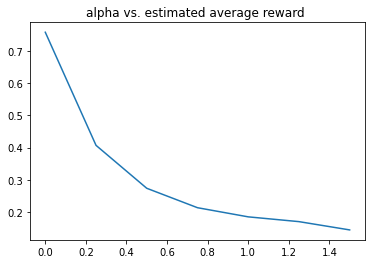

In [299]:
alpha_estimated_rewards = list(estimated_rewards_alphas.items())
alphas   = [alpha for alpha, avg_reward in (alpha_estimated_rewards)]
avg_rwds = [avg_reward for alpha, avg_reward in (alpha_estimated_rewards)]

plt.title('alpha vs. estimated average reward ')
_ = plt.plot(alphas, avg_rwds)

In [302]:
random_policy = False


for alpha in [0.5]:
#     alpha      = 0.25  # scalar factor on confidence interval ( higher the value higher the exploration )
    ctxtVecLen = 100
    arms_ids = list( range(1, kArms+1))
    LinUCBPolicy = LinUCB(arms_ids, alpha, ctxtVecLen)        
    print(LinUCBPolicy)

    armSelCntr = Counter()
    armRewCntr = Counter()

    estimatedRewards = []
    with open('./dataset.txt') as fp:
        for idx, eachRecord in enumerate(fp):
            data_arm = int(eachRecord.split(' ')[0])
            data_reward = float(eachRecord.split()[1])
            covariate_string_list = eachRecord.split()[2:]        
            data_x_array = np.array([float(eCov) for eCov in eachRecord.split()[2:]])
            selected_arm = LinUCBPolicy.select_arm( data_x_array, random_policy )

            if selected_arm == data_arm:
                armSelCntr[selected_arm] += 1
                LinUCBPolicy.update(data_x_array, selected_arm, data_reward) 
                armRewCntr[selected_arm] += data_reward
                
                estimatedRewards.append( sum(armRewCntr.values())/sum(armSelCntr.values()) )



LinUCB Object with 10 arms and with alpha 0.5


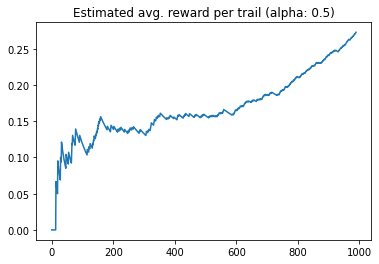

In [307]:
plt.title('Estimated avg. reward per trail (alpha: 0.5)')
_ = plt.plot(estimatedRewards)